# Getting Dataset




In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!pip install saliency
! kaggle datasets download paultimothymooney/breast-histopathology-images

     |████████████████████████████████| 77 kB 4.5 MB/s 
100% 3.09G/3.10G [00:46<00:00, 18.8MB/s]
100% 3.10G/3.10G [00:46<00:00, 70.9MB/s]


In [ ]:
!mkdir DatasetFolder

In [ ]:
! unzip breast-histopathology-images.zip -d DatasetFolder > /dev/null 2>&1

# Loading Data




*   Resize Images and Convert to RGB
*   Add images to X array and labels to y array
*   Perform One-Hot-Encoding on y
*   Plot histogram for y




In [ ]:
import os 
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image



def makeList(path_ , subset_ , label_ , count_p , count_n ):
  X_ = []
  y_ = []
  for im in os.listdir(osp.join(path_ , subset_ , label_)):
    if label_ == '1':
      if count_p > SIZE : # we want to have the same number of IDC+ and IDC- to ensure model learn both well
        continue
      else:
        count_p+=1
    
    if label_ == '0':
      if count_n > SIZE : 
        continue
      else:
        count_n+=1
    image = Image.open(osp.join(path_ , subset_ ,label_ , im))
    image = image.convert('RGB')
    image = image.resize((50,50)) # images are 50x50 by default and colored but this just incase
    X_.append(image)
    y_.append(label_)

  return X_ , y_ , count_p , count_n



path = 'DatasetFolder'
SIZE = 9999
X = []
y = []
countP = 0
countN = 0

for subset in os.listdir(path):
  try:
    int(subset) # this line will make sure the weird file does not enter the the processing
    for label in os.listdir(osp.join(path , subset)):
      if countN > SIZE and label == '0':
        continue 
      if countP > SIZE and label == '1':
        continue 
      X_out , y_out , countP , countN = makeList(path , subset , label , countP , countN)
      X.extend(X_out)
      y.extend(y_out)


  except ValueError:
    # i did this because there is some weird file name
    pass






In [ ]:
X = [np.asarray(image) for image in X]
X = np.array(X)
y = np.array(y)
oneHot = pd.get_dummies(y)
y = y.astype(np.int) # it saves it as strings i have to change it to int
print("X shape",X.shape, "y shape",y.shape, 'y oneHot shape',oneHot.shape)
# 277,524 same number as in dataset , 50x50 size , 3 for RGB




X shape (20000, 50, 50, 3) y shape (20000,) y oneHot shape (20000, 2)


(array([10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

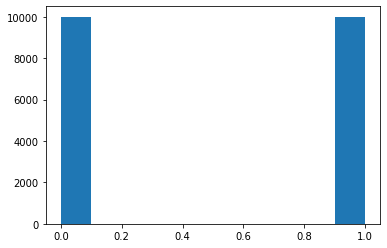

In [ ]:
plt.hist(y)

# Cool Data Images


Display random IDC+ and IDC- images for vizualization





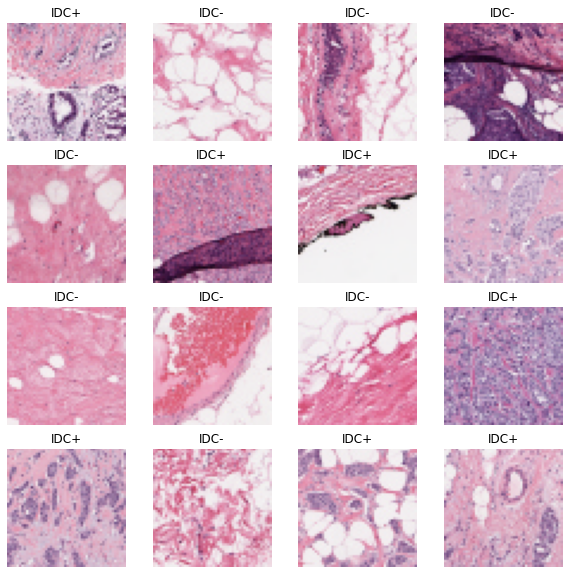

In [ ]:
plt.figure(figsize=(10,10))
from random import randint
for i in range(16):
  title = 'IDC+'
  ax = plt.subplot(4,4,i+1)
  ax.axis('off')
  rando = randint(0,X.shape[0])
  if y[rando]==0:
    title = 'IDC-'
  ax.title.set_text(title)
  ax.imshow(X[rando])

plt.show()

# Model Training 


*   Create Xtrain, ytrain, Xtest, ytest
*   Build Sequential Model
*   Compile Model
*   Display Validation Accuracy






In [ ]:
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report

Xtrain , Xtest , ytrain , ytest = tts(X, oneHot, test_size=0.3, random_state=5)

import gc
del X
del y
del countN
del countP
del SIZE
del path
gc.collect()

64

In [ ]:
Xtrain = Xtrain/255

In [ ]:
Xtest = Xtest/255

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
clear_session()

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same' , activation='relu',kernel_regularizer = l2(0.001), input_shape=(50,50,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same',kernel_regularizer = l2(0.001) , activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same',kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same',kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 128)       0

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(Xtrain,ytrain,epochs=50,validation_split=0.2)

loss, accuracy = model.evaluate(Xtest,ytest,verbose = 0)

Epoch 1/50
700/700 [==============================] - 226s 322ms/step - loss: 0.9269 - accuracy: 0.6582 - val_loss: 0.9430 - val_accuracy: 0.6091
Epoch 2/50
700/700 [==============================] - 230s 328ms/step - loss: 0.8161 - accuracy: 0.7678 - val_loss: 0.7780 - val_accuracy: 0.8118
Epoch 3/50
700/700 [==============================] - 228s 326ms/step - loss: 0.7659 - accuracy: 0.7954 - val_loss: 0.8105 - val_accuracy: 0.7788
Epoch 4/50
700/700 [==============================] - 226s 323ms/step - loss: 0.7444 - accuracy: 0.7988 - val_loss: 0.7552 - val_accuracy: 0.8141
Epoch 5/50
700/700 [==============================] - 224s 320ms/step - loss: 0.7232 - accuracy: 0.8101 - val_loss: 0.7761 - val_accuracy: 0.7950
Epoch 6/50
700/700 [==============================] - 224s 320ms/step - loss: 0.7088 - accuracy: 0.8126 - val_loss: 0.6862 - val_accuracy: 0.8259
Epoch 7/50
700/700 [==============================] - 226s 322ms/step - loss: 0.6923 - accuracy: 0.8178 - val_loss: 0.7319 -

In [ ]:
loss, accuracy = model.evaluate(Xtest,ytest,verbose = 0)
accuracy = 100*round(accuracy,3)
print('The test accuracy is {} %'.format(accuracy))

# Model Evaluation


*   Plot the accuracy curves for training and validation
*   Plot the loss curves for training and validation
*   Implement Saliency Maps using Vanilla Gradient
*   Implement Saliency Maps using SmoothGrad Gradient





In [ ]:
plt.figure(figsize=(30,30))
ax = plt.subplot(4,4 ,1)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'val'])
ax = plt.subplot(4,4 , 2)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'val'])

In [ ]:
ypred = model.predict(Xtest)
ypred = np.argmax(ypred,axis=1)
ytrue = np.argmax(ytest.values,axis=1)
print(classification_report(y_pred=ypred, y_true=ytrue))

In [ ]:
import saliency.core as saliency

In [ ]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [ ]:
def ShowIm(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im,cmap=plt.cm.jet, vmin=0, vmax=1)
  plt.title(title)


In [ ]:
for i in range(10):
  class_idx_str = i
  im = Xtest[class_idx_str]
  predictions = model(np.array([im]))
  prediction_class = np.argmax(predictions[0])
  call_model_args = {class_idx_str: prediction_class}

  gradient_saliency = saliency.GradientSaliency()

  vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
  smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

  vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
  smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

  ROWS = 1
  COLS = 10
  UPSCALE_FACTOR = 20
  plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))


  ShowIm(vanilla_mask_grayscale, title='Vanilla Gradient', ax=plt.subplot(ROWS, COLS, 1))
  ShowIm(smoothgrad_mask_grayscale, title='SmoothGrad', ax=plt.subplot(ROWS, COLS, 2))

  ax= plt.subplot(ROWS,COLS,3)
  ax.axis('off')
  ax.title.set_text('Predicted '+str(prediction_class))
  ax.imshow(im)